# Preliminaries

In [1]:
import os.path
import datetime, time

import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

## Economic Model

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(27, 27)

In [5]:
if os.path.exists("/tmp/agent_goods.log"):
    agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))
    #TODO: assumes every agent produces exactly one good
    agent_goods = agent_goods_df.idxmax(axis=1)
    loaded_agent_goods_from_file = True
else:
    loaded_agent_goods_from_file = False

## Loading Other Data

In [6]:
buy_price_df = serialization.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = serialization.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = serialization.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = serialization.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = serialization.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [7]:
# if we were not able to load agent_goods_df above, infer it from sell prices now
if not loaded_agent_goods_from_file:
    g = sell_price_df.drop("tick", axis=1).groupby("agent").min()
    agent_goods_df = np.zeros((len(g),production_chain.num_products), dtype=int)
    agent_goods = np.full((len(g),), -3)
    for i in g.index:
        if g.loc[i].min() > 0:
            agent_goods_df[i,g.loc[i].argmin()] = 1
            agent_goods[i] = g.loc[i].argmin()
    agent_goods_df = pd.DataFrame(agent_goods_df)
    agent_goods = pd.Series(agent_goods)

In [8]:
production_goods = agent_goods_df @ production_chain_df.T

In [9]:
columns = ["tick", "product", "buyer", "seller", "price", "amount"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [10]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [11]:
# if you want to interpret tick as datetime in stellarpunk universe
#transaction_df["tick"] += time.mktime(datetime.datetime(2234, 4, 3).timetuple())
#transaction_df["tick"] = pd.to_datetime(transaction_df["tick"], unit="s")

In [12]:
cannot_buy_df = serialization.read_tick_log_to_df(open("/tmp/cannot_buy.log", "rb"), index_name="agent", fill_values=0.).reset_index()
cannot_sell_df = serialization.read_tick_log_to_df(open("/tmp/cannot_sell.log", "rb"), index_name="agent", fill_values=0.).reset_index()

In [13]:
balance_df = serialization.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [14]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = serialization.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

In [15]:
#production_efficiency_df = serialization.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")

# Transactions

## Market Overview

In [16]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
0,686.0,19988.877151
1,2284.0,58254.678620
2,2000.0,45699.694051
3,2500.0,12807.157673
4,500.0,3867.844614
5,2000.0,8459.671564
19,21.0,210510.076165
20,6.0,57405.067231
21,1.0,15727.730137


In [17]:
#transaction_tick_grouping = "tick"
transaction_tick_grouping = transaction_df["tick"] // (5*60)

50 transactions total


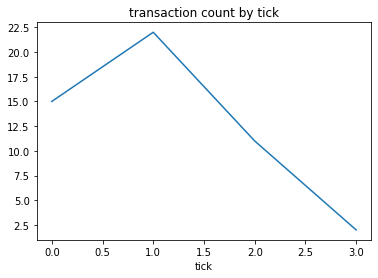

In [18]:
transaction_df.groupby(transaction_tick_grouping)["price"].count().plot()
plt.title("transaction count by tick")
print(f'{len(transaction_df)} transactions total')

Text(0.5, 1.0, 'product 0 transaction count per tick')

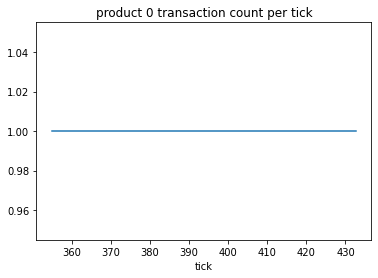

In [19]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

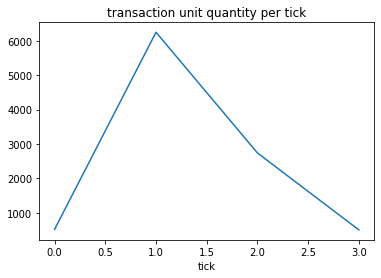

In [20]:
transaction_df.groupby(transaction_tick_grouping)["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

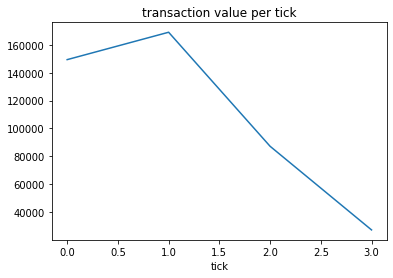

In [21]:
transaction_df.groupby(transaction_tick_grouping)["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

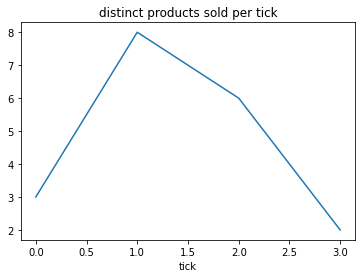

In [22]:
transaction_df.groupby(transaction_tick_grouping)["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

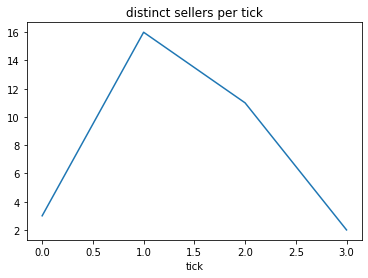

In [23]:
transaction_df.groupby(transaction_tick_grouping)["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

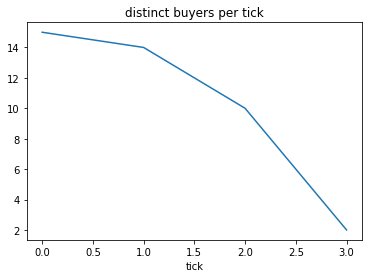

In [24]:
transaction_df.groupby(transaction_tick_grouping)["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [25]:
transaction_df["seller"].nunique()

25

In [26]:
transaction_df["buyer"].nunique()

35

In [27]:
transaction_df["product"].nunique()

9

<AxesSubplot:>

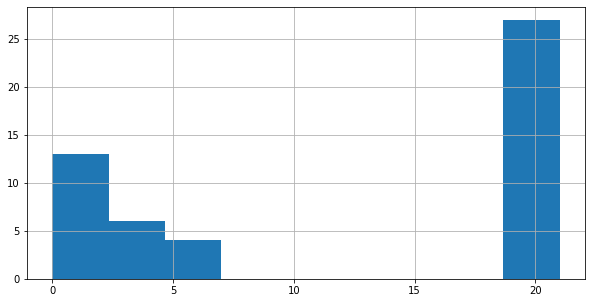

In [28]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

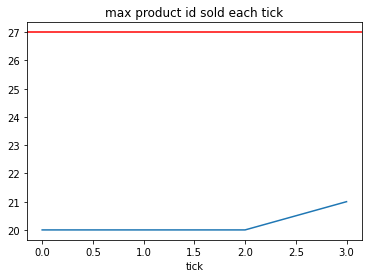

In [29]:
transaction_df.groupby(transaction_tick_grouping)["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [30]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

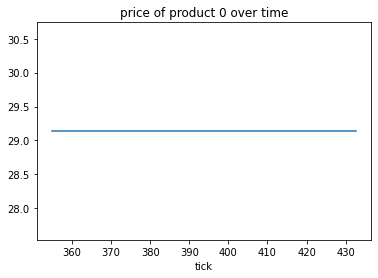

In [31]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean().plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 3 over time')

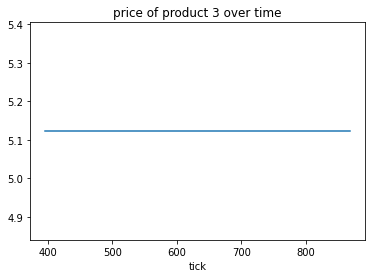

In [32]:
transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean().plot()
plt.title("price of product 3 over time")

<AxesSubplot:>

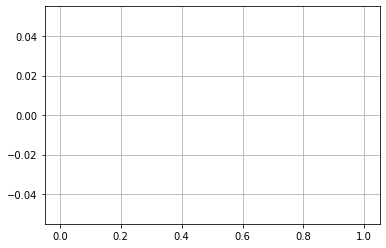

In [33]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

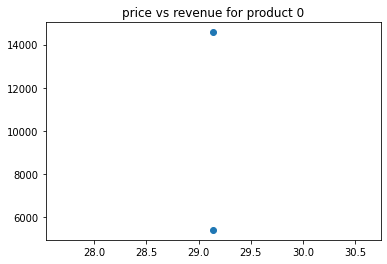

In [34]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

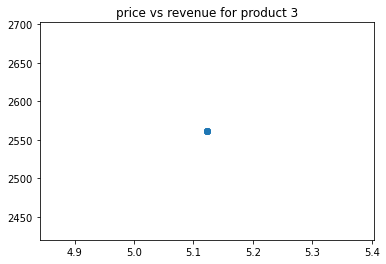

In [35]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [36]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,product,buyer,seller,price,amount,value
20,354.833333,0,22,20,29.138305,500.0,14569.152442
30,432.700000,0,22,74,29.138305,186.0,5419.724709


In [37]:
transaction_df.groupby("product").agg({"tick":"max", "price":"mean", "amount":"sum", "value":"sum"})

,tick,price,amount,value
product,,,,
0,432.700000,29.138305,686.0,19988.877151
1,816.933333,25.505551,2284.0,58254.678620
2,919.033333,22.849847,2000.0,45699.694051
3,868.600000,5.122863,2500.0,12807.157673
4,469.100000,7.735689,500.0,3867.844614
5,827.633333,4.229836,2000.0,8459.671564
19,630.966667,10024.289341,21.0,210510.076165
20,874.333333,9567.511205,6.0,57405.067231
21,923.733333,15727.730137,1.0,15727.730137


## Transaction Graph

### By Agent

In [38]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,5,87,324.0
1,8,14,500.0
2,11,50,2.0
3,15,50,1.0
4,22,20,500.0
5,22,74,186.0
6,27,20,500.0
7,27,32,500.0
8,27,84,500.0
9,27,98,500.0


In [39]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [40]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [41]:
G = nx.relabel_nodes(G, labels)

In [42]:
nx.is_directed_acyclic_graph(G)

True

In [43]:
# this is pretty slow for lots of agents
#plt.figure(figsize=(15, 15))
#pos = graphviz_layout(G, prog='dot')
#nx.draw(G, pos, with_labels=True, arrows=True)
#nx.draw_networkx_edge_labels(G, pos)
#plt.show()

### By Good

In [44]:

augmented_transaction_df = transaction_df.merge(agent_goods.rename("buyer_product"), how="left", left_on="buyer", right_index=True)
augmented_transaction_df["buyer_product"].fillna(-2, inplace=True)
product_flow = augmented_transaction_df.groupby(["product", "buyer_product"])["value"].sum().to_frame().reset_index().rename({"buyer_product":"target", "product":"source", "amount":"value"}, axis=1)

In [47]:
# discount intermediate sales by final sales
# this represents, e.g., traders carrying goods from one station to another
# if they completed their trade route we don't want to display that in the product flow graph
final_sales = product_flow[product_flow["target"] != -3].groupby("source")["value"].sum()
final_sales_df = pd.DataFrame(final_sales.rename("final_value")).reset_index()
final_sales_df["target"] = -3
product_flow["value"] = product_flow["value"] - product_flow.merge(final_sales_df, how="left", on=["source", "target"])["final_value"].fillna(0.)

In [49]:
set(agent_goods_df.columns) - set(product_flow["source"].unique())

{6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26}

In [50]:
set(agent_goods_df.columns) - set(product_flow["target"].unique())

{0, 1, 2, 3, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}

In [51]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
sankey = SankeyWidget(layout=Layout(height='680', width='1024'), links=product_flow.to_dict("records"))
sankey

SankeyWidget(layout=Layout(height='680', width='1024'), links=[{'source': 0, 'target': 6, 'value': 19988.87715…

In [52]:
from IPython.display import (
    Image,
    SVG
)
import base64
data = base64.decodebytes(bytes(sankey.png, 'ascii'))
Image(data)

## Indicators by Market

In [53]:
transactions_by_product = pd.DataFrame({"producers":agent_goods_df.sum(axis=0), "sellers":transaction_df.groupby("product")["seller"].nunique()})
transactions_by_product["zero_sales"] = transactions_by_product["producers"] - transactions_by_product["sellers"]
transactions_by_product["seller_value_cv"] = transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").std() / transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").mean()
transactions_by_product["transactions"] = transaction_df.groupby("product")["price"].count()
transactions_by_product["total_amount"] = transaction_df.groupby("product")["amount"].sum()
transactions_by_product["total_value"] = transaction_df.groupby("product")["value"].sum()
transactions_by_product["price"] = transaction_df.groupby("product")["price"].mean()
transactions_by_product["price_cv"] = transaction_df.groupby("product")["price"].std() / transaction_df.groupby("product")["price"].mean()
transactions_by_product["first_tick"] = transaction_df.groupby("product")["tick"].min()
transactions_by_product["last_tick"] = transaction_df.groupby("product")["tick"].max()

transactions_by_product

,producers,sellers,zero_sales,seller_value_cv,transactions,total_amount,total_value,price,price_cv,first_tick,last_tick
0,1,2.0,-1.0,0.647322,2.0,686.0,19988.877151,29.138305,0.00000,354.833333,432.700000
1,0,5.0,-5.0,0.211467,6.0,2284.0,58254.678620,25.505551,0.00000,339.966667,816.933333
2,0,4.0,-4.0,0.000000,5.0,2000.0,45699.694051,22.849847,0.00000,416.500000,919.033333
3,0,4.0,-4.0,0.400000,5.0,2500.0,12807.157673,5.122863,0.00000,395.933333,868.600000
4,0,1.0,-1.0,NaN,1.0,500.0,3867.844614,7.735689,NaN,469.100000,469.100000
5,0,4.0,-4.0,0.000000,4.0,2000.0,8459.671564,4.229836,0.00000,233.266667,827.633333
6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'mean prices by products')

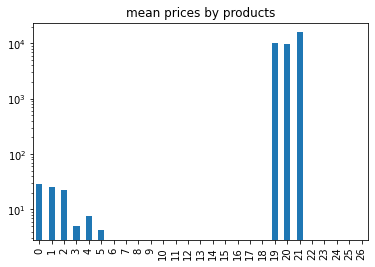

In [54]:
transactions_by_product["price"].plot.bar()
plt.yscale("log")
plt.title("mean prices by products")

Text(0.5, 1.0, 'cv by product')

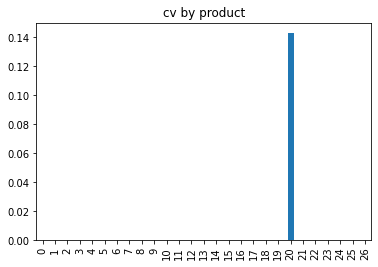

In [55]:
transactions_by_product["price_cv"].plot.bar()
plt.title("cv by product")

Text(0.5, 0.98, 'Prices for goods over time')

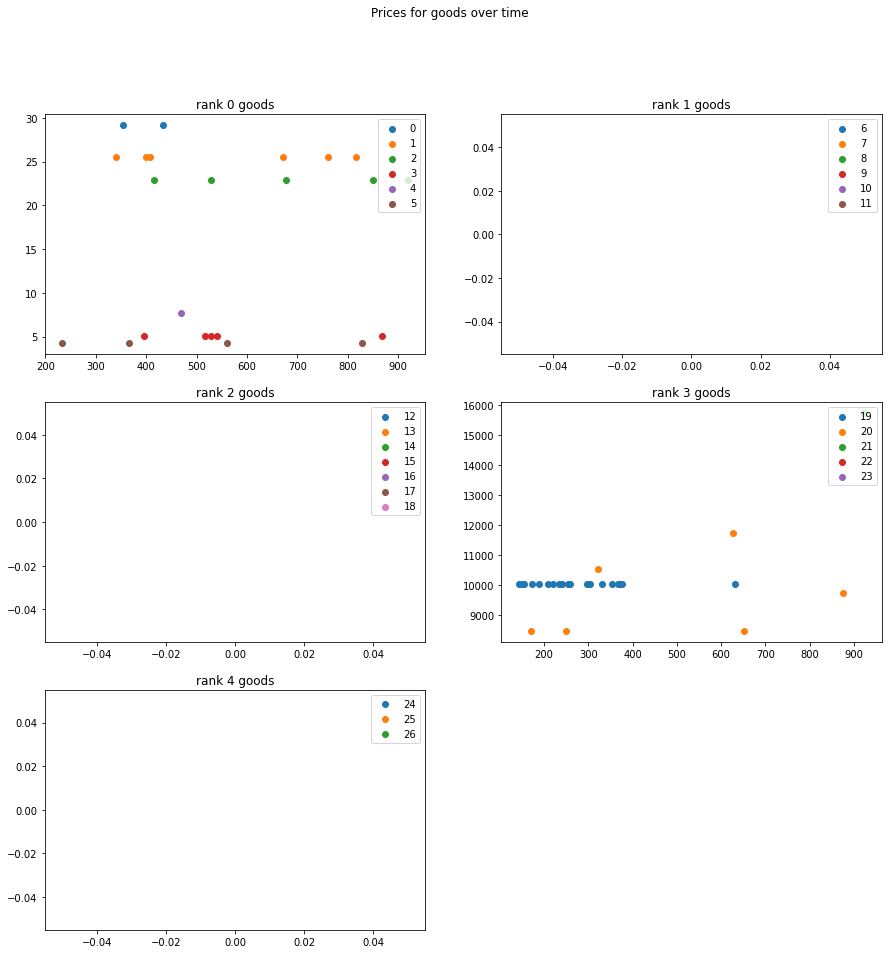

In [56]:
price_by_tick = transaction_df.groupby(["tick", "product"])["price"].mean().to_frame().reset_index()

a = np.insert(production_chain.ranks.cumsum(), 0,0)
rank_ranges = list(zip(a[0:-1], a[1:]))

fig, axs = plt.subplots(int(np.ceil(len(rank_ranges)/2)),2, figsize=(15,15))
if len(rank_ranges) % 2 == 1:
    fig.delaxes(axs.flatten()[-1])
for i,rng in enumerate(rank_ranges):
    ax = axs.flatten()[i]
    for product in range(rng[0], rng[1]):
        ax.scatter(price_by_tick[price_by_tick["product"] == product]["tick"], price_by_tick[price_by_tick["product"] == product]["price"], label=f'{product}')
    ax.title.set_text(f'rank {i} goods')
    ax.legend(loc="upper right")
    
fig.suptitle("Prices for goods over time")

In [57]:
buy_price_melt = buy_price_df.melt(id_vars=["agent", "tick"], value_vars=list(range(production_chain.ranks.sum())), var_name="product", value_name="price")
buy_price_melt = buy_price_melt[buy_price_melt["price"] > 0]
buy_price_by_tick = buy_price_melt.groupby(["tick", "product"])["price"].max()
sell_price_melt = sell_price_df.melt(id_vars=["agent", "tick"], value_vars=list(range(production_chain.ranks.sum())), var_name="product", value_name="price")
sell_price_melt = sell_price_melt[sell_price_melt["price"] < np.inf]
sell_price_by_tick = sell_price_melt.groupby(["tick", "product"])["price"].min()

Text(0.5, 0.98, 'Buy/sell price diffs for goods over time')

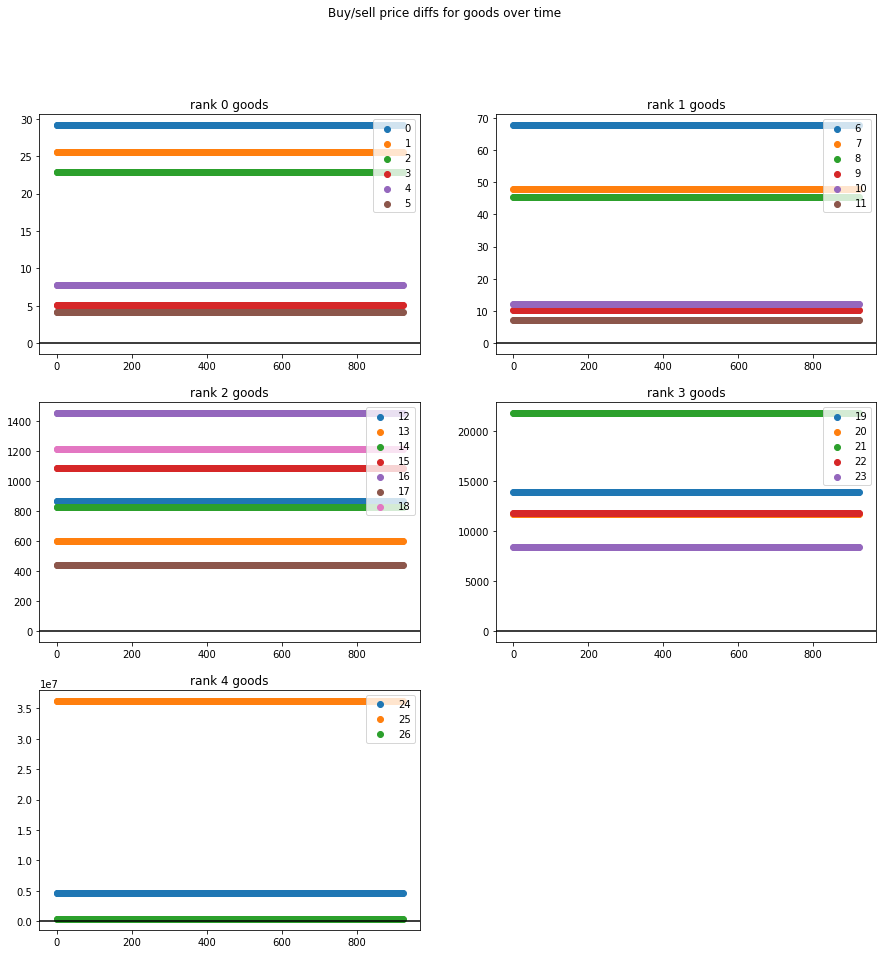

In [58]:
price_diffs = (buy_price_by_tick - sell_price_by_tick).to_frame().reset_index()

a = np.insert(production_chain.ranks.cumsum(), 0,0)
rank_ranges = list(zip(a[0:-1], a[1:]))

fig, axs = plt.subplots(int(np.ceil(len(rank_ranges)/2)),2, figsize=(15,15))
if len(rank_ranges) % 2 == 1:
    fig.delaxes(axs.flatten()[-1])
for i,rng in enumerate(rank_ranges):
    ax = axs.flatten()[i]
    for product in range(rng[0], rng[1]):
        ax.scatter(price_diffs[price_diffs["product"] == product]["tick"], price_diffs[price_diffs["product"] == product]["price"], label=f'{product}')
    ax.axhline(0, color="black")
    ax.title.set_text(f'rank {i} goods')
    ax.legend(loc="upper right")
    
fig.suptitle("Buy/sell price diffs for goods over time")

# Balance

In [59]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0.033333,20000.0
1,0.033333,20000.0
2,0.033333,20000.0
3,0.033333,0.0
4,0.033333,20000.0
...,...,...
94,0.033333,20000.0
95,0.033333,20000.0
96,0.033333,0.0


In [60]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,922.633333,20000.000000
1,922.633333,20000.000000
2,922.633333,20000.000000
3,922.633333,0.000000
4,922.633333,20000.000000
...,...,...
94,922.633333,6.383853
95,922.633333,8250.491005
96,922.633333,0.000000


In [61]:
#balance_df.groupby("tick")["balance"].sum().plot()

In [62]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count        99.000000
mean      12070.707071
std       14533.741548
min           0.000000
25%           0.000000
50%       20000.000000
75%       20000.000000
max      110000.000000
Name: balance, dtype: float64

In [63]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count        99.000000
mean      12504.245511
std       26943.315738
min           0.000000
25%           0.000000
50%           6.383853
75%       20000.000000
max      230510.076165
Name: balance, dtype: float64

In [64]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

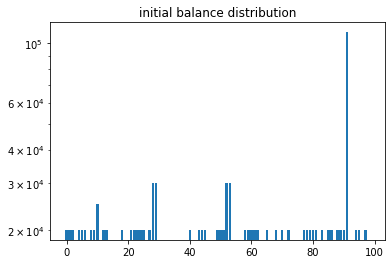

In [65]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

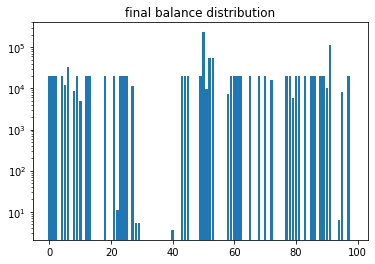

In [66]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [67]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
          ...     
94   -19993.616147
95   -11749.508995
96        0.000000
97        0.000000
98        0.000000
Name: balance, Length: 99, dtype: float64

<AxesSubplot:xlabel='agent'>

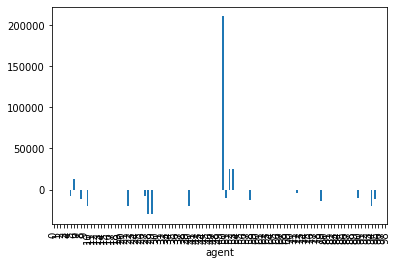

In [68]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]).plot.bar()

In [69]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0     20000.000000
1     20000.000000
2     20000.000000
3         0.000000
4     20000.000000
          ...     
94        6.383853
95     8250.491005
96        0.000000
97    20000.000000
98        0.000000
Name: balance, Length: 99, dtype: float64

In [70]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
45144,0,922.633333,20000.000000
45145,1,922.633333,20000.000000
45146,2,922.633333,20000.000000
45147,3,922.633333,0.000000
45148,4,922.633333,20000.000000
45149,5,922.633333,11736.201457
45150,6,922.633333,32752.775530
45151,7,922.633333,0.000000
45152,8,922.633333,8575.076487
45153,9,922.633333,20000.000000


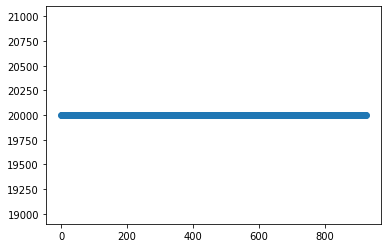

In [71]:
plt.scatter(balance_df[balance_df["agent"] == 1]["tick"],balance_df[balance_df["agent"] == 1]["balance"])

In [72]:
#for agent in balance_df["agent"].unique():
#    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [73]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,1.000000
1,1.000000
2,1.000000
3,NaN
4,1.000000
...,...
94,0.000319
95,0.412525
96,NaN


# Inventory

## Last Tick Inventory

In [74]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,17,18,19,20,21,22,23,24,25,26
45144,0,922.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45145,1,922.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45146,2,922.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45147,3,922.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45148,4,922.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45238,94,922.633333,0.0,0.0,794.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45239,95,922.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,25.0,0.0
45240,96,922.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45241,97,922.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [75]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,tick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,297.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [76]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.0,0.0,794.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [77]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.0,0.0,793.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-249.0,-353.0,-127.0,0.0,-661.0,0.0,0.0,0.0,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [78]:
agent_id = 22
target_tick = np.inf

target_tick = np.clip(target_tick, 0, inventory_df["tick"].max())

#inv_s = inventory_df[inventory_df["tick"] == target_tick].set_index("agent").loc[agent_id].drop("tick")
inv_s = inventory_df.drop("tick", axis=1).groupby("agent").mean().loc[agent_id]
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,378.126915,1.0,9.0,369.126915,42.014102
1,0.000000,0.0,0.0,0.000000,NaN
2,0.000000,0.0,0.0,0.000000,NaN
3,0.000000,0.0,0.0,0.000000,NaN
4,0.000000,0.0,0.0,0.000000,NaN
5,0.000000,0.0,0.0,0.000000,NaN
6,247.411379,0.0,0.0,247.411379,inf
7,0.000000,0.0,0.0,0.000000,NaN
8,0.000000,0.0,0.0,0.000000,NaN
9,0.000000,0.0,0.0,0.000000,NaN


In [79]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == target_tick)]

,agent,tick,balance
45166,22,922.633333,11.122849


In [80]:
buy_price_df[(buy_price_df["tick"] == target_tick) & (buy_price_df["agent"] == agent_id)].T

,45166
agent,22.000000
tick,922.633333
0,29.138305
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [81]:
buy_budget_df[(buy_budget_df["tick"] == target_tick) & (buy_budget_df["agent"] == agent_id)].T

,45166
agent,22.000000
tick,922.633333
0,inf
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [82]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].describe()

count    457.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: 22, dtype: float64

# Buy and Sell Prices

In [83]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
dtype: float64

## Market Analysis for one Good

### Overview of one Market

In [84]:
product_id = 3
min_ticks = 0
max_ticks = np.inf

max_ticks = np.clip(max_ticks, 0, sell_price_df["tick"].max())

dfsp = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)

df1 = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df1_mean = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].mean().to_frame()
df1_max = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].max().to_frame()
dfms = dfms[dfms[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id]
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id]

buyer_df = buy_budget_df[(buy_budget_df[product_id] > 0) & buy_budget_df["tick"].between(min_ticks, max_ticks)][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["tick"].between(min_ticks, max_ticks) & inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


Seller prices

In [85]:
sell_price_df[(sell_price_df[product_id] < np.inf) & sell_price_df["tick"].between(min_ticks, max_ticks)].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Buyer Prices

In [86]:
buyer_df.groupby("agent")[f'{product_id}_price'].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
4,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
58,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
59,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
61,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
62,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
70,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
80,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
85,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863


#### Market Volume

nan


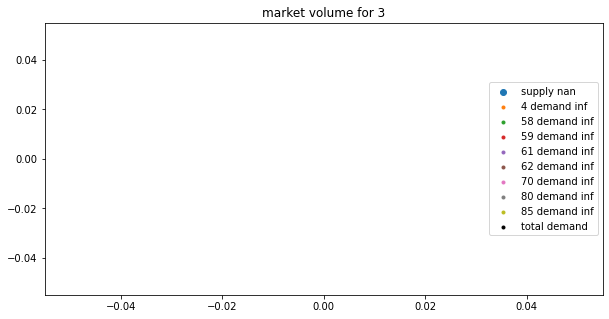

In [87]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

In [88]:
seller_df[seller_df > 0].index.to_series().describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: tick, dtype: float64

In [89]:
seller_df.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 3, dtype: float64

In [90]:
buyer_df.groupby("agent")["units"].describe()

/home/nick/src/stellarpunk/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/nick/src/stellarpunk/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/nick/src/stellarpunk/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/nick/src/stellarpunk/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/nick/src/stellarpunk/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/nick/src/stellarpunk/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: inva

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
4,457.0,inf,NaN,inf,NaN,NaN,NaN,inf
58,457.0,inf,NaN,inf,NaN,NaN,NaN,inf
59,457.0,inf,NaN,inf,NaN,NaN,NaN,inf
61,457.0,inf,NaN,inf,NaN,NaN,NaN,inf
62,457.0,inf,NaN,inf,NaN,NaN,NaN,inf
70,457.0,inf,NaN,inf,NaN,NaN,NaN,inf
80,457.0,inf,NaN,inf,NaN,NaN,NaN,inf
85,457.0,inf,NaN,inf,NaN,NaN,NaN,inf


In [91]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id])[0])][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
4,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
df2[product_id].max()

5.122863069243424

In [93]:
df2.groupby("tick")[product_id].describe().describe()

,count,mean,std,min,25%,50%,75%,max
count,457.0,4.570000e+02,457.0,4.570000e+02,4.570000e+02,4.570000e+02,4.570000e+02,4.570000e+02
mean,8.0,5.122863e+00,0.0,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00
std,0.0,8.891518e-16,0.0,8.891518e-16,8.891518e-16,8.891518e-16,8.891518e-16,8.891518e-16
min,8.0,5.122863e+00,0.0,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00
25%,8.0,5.122863e+00,0.0,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00
50%,8.0,5.122863e+00,0.0,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00
75%,8.0,5.122863e+00,0.0,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00
max,8.0,5.122863e+00,0.0,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00,5.122863e+00


#### Market Price

is there a transaction?
do the sellers have inventory?
do any buyers demand goods?
are prices compatible?
is at least one agent in the cannot buy state (> 100 ticks)


Text(0.5, 1.0, 'price chart for 3')

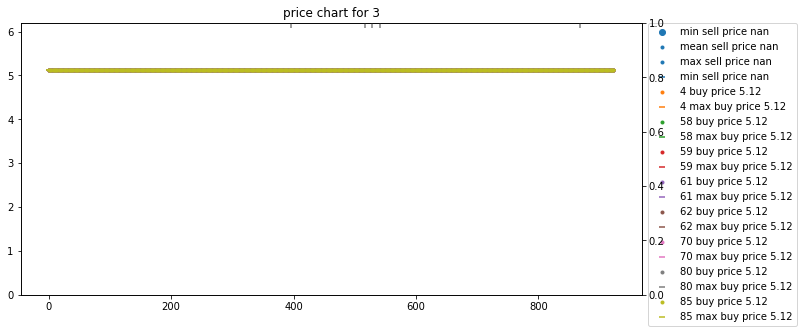

In [94]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1.index, df1[product_id], label=f'min sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(df1_mean.index, df1_mean[product_id], label=f'mean sell price {df1_mean[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(df1_mean.index, df1_max[product_id], label=f'max sell price {df1_max[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(dfms.index, dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
if len(df2) > 0:
    plt.ylim(0, df2[product_id].max()*1.1)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
print("is there a transaction?")
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
print("do the sellers have inventory?")
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
print("do any buyers demand goods?")
ax2.vlines(buyer_df["tick"].unique()[(buyer_df.groupby("tick")["units"].sum() > 0)], ymin=0.94, ymax=0.96, color="darkred")
print("are prices compatible?")
price_diff = (df2.groupby("tick")[product_id].max() - df1[product_id]).rename("price_diff")
ax2.vlines(df1.join(price_diff[price_diff>0]).index, ymin=0.92, ymax=0.94, color="darkgreen")
print("is at least one agent in the cannot buy state (> 100 ticks)")
ax2.vlines(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)]["tick"].unique()[(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)].groupby("tick")[product_id].max() > 100)], ymin=0.90, ymax=0.92, color="darkred")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



In [95]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["product"] == product_id)]

,tick,product,buyer,seller,price,amount,value
26,395.933333,3,58,31,5.122863,500.0,2561.431535
32,516.200000,3,58,54,5.122863,500.0,2561.431535
33,527.900000,3,58,63,5.122863,500.0,2561.431535
35,540.566667,3,58,46,5.122863,500.0,2561.431535
46,868.600000,3,58,63,5.122863,500.0,2561.431535


#### Ticks when max buy price changes a lot

In [96]:
def consecutive_diffs(x):
    return x.iloc[1] - x.iloc[0]
    print(x)
    raise Exception(x.__class__)
mb_diffs = dfmb.set_index("tick").groupby("agent")[product_id].rolling(2).apply(consecutive_diffs)
mb_diffs.to_frame().sort_values(["agent", product_id], key=abs, ascending=False).groupby("agent").head(5)

3
agent tick          
85    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0
80    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0
70    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0
62    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0
61    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0
59    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0
58    2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0
4     2.033333   0.0
      4.066667   0.0
      6.100000   0.0
      8.133333   0.0
      10.166667  0.0

#### Balance

(0.0, 20640.35788365543)

<Figure size 432x288 with 0 Axes>

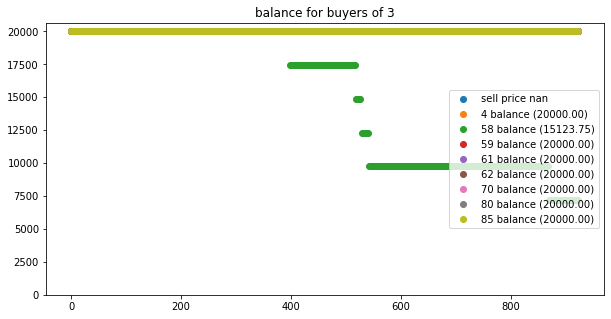

In [97]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [98]:
np.where(agent_goods_df[product_id])

(array([], dtype=int64),)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.0)

<Figure size 432x288 with 0 Axes>

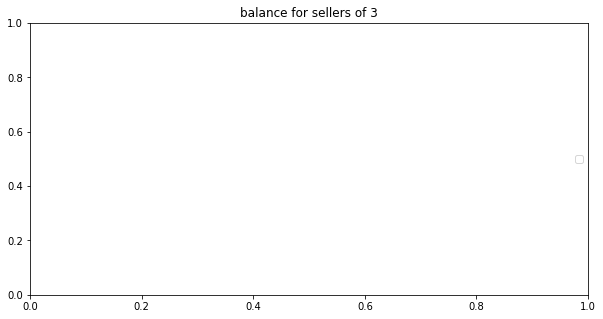

In [99]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
#plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(np.where(agent_goods_df[product_id])[0], colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for sellers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

### Sellers for the Market

In [100]:
np.where(agent_goods_df[product_id] == 1)

(array([], dtype=int64),)

Amounts Sold

In [101]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["amount"].sum()

seller
31     500.0
46     500.0
54     500.0
63    1000.0
Name: amount, dtype: float64

Time ranges of sales

In [102]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
31,1.0,395.933333,NaN,395.933333,395.933333,395.933333,395.933333,395.933333
46,1.0,540.566667,NaN,540.566667,540.566667,540.566667,540.566667,540.566667
54,1.0,516.200000,NaN,516.200000,516.200000,516.200000,516.200000,516.200000
63,2.0,698.250000,240.91128,527.900000,613.075000,698.250000,783.425000,868.600000


Prices for transactions

In [103]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
31,1.0,5.122863,NaN,5.122863,5.122863,5.122863,5.122863,5.122863
46,1.0,5.122863,NaN,5.122863,5.122863,5.122863,5.122863,5.122863
54,1.0,5.122863,NaN,5.122863,5.122863,5.122863,5.122863,5.122863
63,2.0,5.122863,0.0,5.122863,5.122863,5.122863,5.122863,5.122863


Desired sell prices

In [104]:
sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Min Sell Prices

In [105]:
min_sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Product inventory

In [106]:
inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max


In [107]:
for agent in np.where(agent_goods_df[product_id])[0]:
    plt.scatter(inventory_df[inventory_df["agent"] == agent]["tick"], inventory_df[inventory_df["agent"] == agent][product_id])

Input inventory

In [108]:
production_needs = pd.Series(production_chain.adj_matrix[:,product_id] * production_chain.batch_sizes[product_id])
production_needs[production_needs > 0].to_frame()

,0


In [109]:
production_needs[production_needs > 0].index.to_list()

[]

In [110]:
input_ids = production_needs[production_needs > 0].index.to_list()
inventory_melt = pd.melt(inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["agent", "tick"]+input_ids], id_vars=["agent", "tick"], value_vars=input_ids, var_name="product")
input_inventory_info = inventory_melt.groupby(["agent", "product"])["value"].describe()
input_inventory_info

,count,mean,std,min,25%,50%,75%,max


In [111]:
inventory_melt.groupby(["agent","tick"])["value"].min().groupby("agent").describe()

,count,mean,std,min,25%,50%,75%,max


Cannot sell ticks by seller

In [112]:
relevant_cannot_sell_df = cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["tick", "agent", product_id]]
relevant_cannot_sell_df.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'cannot sell 3')

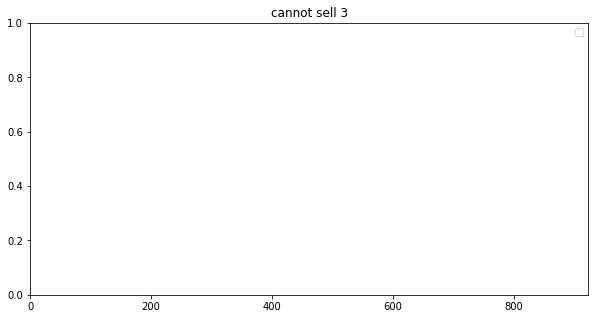

In [113]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_sell_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_sell_df[(relevant_cannot_sell_df["agent"] == agent) & (relevant_cannot_sell_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.xlim(min_ticks, max_ticks)
plt.title(f'cannot sell {product_id}')

### Buyers for the Market

Total Amount Purchased

In [114]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["amount"].sum()

buyer
58    2500.0
Name: amount, dtype: float64

Time Ranges of Purchase

In [115]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
58,5.0,569.84,176.772599,395.933333,516.2,527.9,540.566667,868.6


Prices Paid

In [116]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
58,5.0,5.122863,0.0,5.122863,5.122863,5.122863,5.122863,5.122863


Desired Buy Prices

In [117]:
buy_price_df[buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
4,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
58,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
59,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
61,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
62,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
70,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
80,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
85,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863


In [118]:
max_buy_price_df[max_buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
4,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
58,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
59,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
61,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
62,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
70,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
80,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
85,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863


Cannot buy ticks by buyer

In [119]:
relevant_cannot_buy_df = cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id]>0)[0])][["tick", "agent", product_id]]
relevant_cannot_buy_df.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
4,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Behavior of one buyer

In [120]:
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
price_diff[price_diff > 0].index

Float64Index([0.03333333333333333,   2.033333333333336,   4.066666666666662,
                6.099999999999988,   8.133333333333315,  10.166666666666641,
               12.199999999999967,  14.233333333333293,    16.2333333333333,
                 18.2333333333334,
              ...
                904.3333333331682,   906.3666666664997,   908.3999999998312,
                910.4333333331626,   912.4666666664941,   914.4999999998256,
                916.5333333331571,   918.5666666664886,     920.59999999982,
                922.6333333331515],
             dtype='float64', name='tick', length=457)

is transaction?
cannot buy?
has budget?
buy price at max price?
price compatible


Text(0.5, 1.0, 'behavior for buyer 4')

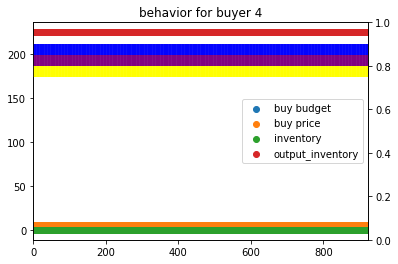

In [121]:
agent_id = relevant_cannot_buy_df["agent"].unique()[0]
agent_output = agent_goods_df.loc[agent_id].idxmax()
plt.scatter(buy_budget_df[buy_budget_df["agent"] == agent_id]["tick"], buy_budget_df[buy_budget_df["agent"] == agent_id][product_id], label=f'buy budget')
plt.scatter(buy_price_df[buy_price_df["agent"] == agent_id]["tick"], buy_price_df[buy_price_df["agent"] == agent_id][product_id], label=f'buy price')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][product_id], label=f'inventory')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][agent_output], label=f'output_inventory')
plt.legend(loc="right")
ax2 = plt.twinx()

print("is transaction?")
ax2.vlines(transaction_df[(transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]["tick"], ymin=0.95, ymax=1.0, color="green")
print("cannot buy?")
ax2.vlines(cannot_buy_df[(cannot_buy_df["agent"] == agent_id) & (cannot_buy_df[product_id] > 0)]["tick"], ymin=0.90, ymax=0.95, color="red")
print("has budget?")
ax2.vlines(buy_budget_df[(buy_budget_df["agent"] == agent_id) & (buy_budget_df[product_id] > 0)]["tick"], ymin=0.85, ymax=0.90, color="blue")
print("buy price at max price?")
ax2.vlines(buy_price_df[(buy_price_df["agent"] == agent_id) & (max_buy_price_df[product_id] - buy_price_df[product_id] < econ_sim.PRICE_EPS)]["tick"], ymin=0.80, ymax=0.85, color="purple")
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
print("price compatible")
ax2.vlines(price_diff[price_diff > 0].index, ymin=0.75, ymax=0.80, color="yellow")
ax2.set_ylim(0,1)

plt.xlim(min_ticks, max_ticks)

plt.title(f'behavior for buyer {agent_id}')

In [122]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]

,tick,product,buyer,seller,price,amount,value


<AxesSubplot:xlabel='tick'>

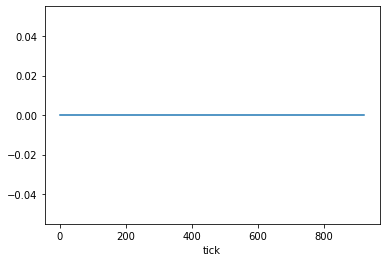

In [123]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & (cannot_buy_df["agent"] == agent_id)].set_index("tick")[product_id].plot()

When cannot buy exceeds 0

In [124]:
relevant_cannot_buy_df[relevant_cannot_buy_df[product_id] > 0].groupby("agent")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max


(0.0, 922.6333333331515)

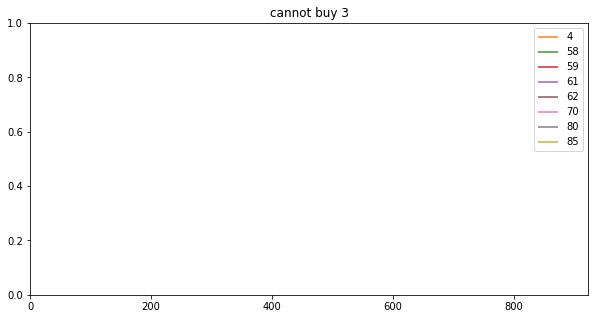

In [125]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_buy_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_buy_df[(relevant_cannot_buy_df["agent"] == agent) & (relevant_cannot_buy_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.title(f'cannot buy {product_id}')
plt.xlim(min_ticks, max_ticks)

## Buy/Sell Price Investigation

In [126]:
df1[product_id].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 3, dtype: float64

In [127]:
df2.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
4,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
58,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
59,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
61,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
62,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
70,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
80,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863
85,457.0,5.122863,8.891518e-16,5.122863,5.122863,5.122863,5.122863,5.122863


In [128]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

IndexError: single positional indexer is out-of-bounds

In [ ]:
(df2.groupby("tick")[product_id].max() - df1[product_id]).describe()

In [ ]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

In [ ]:
(dfmb.groupby("tick")[product_id].max() - dfms[product_id]).describe()

In [ ]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

## Larger Scale Market Analysis

In [ ]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

### Supply Deficit

For each product, on average how many units of supply above demand are on the market

In [ ]:
transaction_df.groupby("product")["amount"].sum() / transaction_df["tick"].max()

In [ ]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean().drop("agent")
surplus_df = pd.DataFrame({
    "agents": agent_goods_df.sum(axis=0),
    "supply": supply_units_mean,
    "supply_cv": ((supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()).drop("agent"),
    "demand": demand_units_mean,
    "demand_cv": (demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean(),
    "surplus": supply_units_mean - demand_units_mean
})
surplus_df["min_input_surplus"] = 1./(pd.DataFrame(production_chain.adj_matrix).replace(0, np.nan).multiply(1./surplus_df["surplus"], axis=0).max(axis=0).fillna(np.inf))
surplus_df

In [ ]:
surplus_df["surplus"] + surplus_df["min_input_surplus"]

## Cannot Buy or Sell

In [ ]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1)

In [ ]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_buy_df["agent"].nunique())))
plt.title("distribution of max cannot buy ticks for agents")

Summary of cannot buy by good

In [ ]:
maxes = cannot_buy_df.drop("tick", axis=1).groupby("agent").max()
describe_series = []
for product in agent_goods_df.columns:
    describe_series.append(maxes[product][production_goods[product] > 0].describe())
cannot_buy_summary = pd.concat(describe_series, axis=1).T
cannot_buy_summary["cv"] = cannot_buy_summary["std"] / cannot_buy_summary["mean"]
cannot_buy_summary["min_tick"] = transaction_df.groupby("product")["tick"].min()
cannot_buy_summary["max_tick"] = transaction_df.groupby("product")["tick"].max()
cannot_buy_summary

In [ ]:
cannot_sell_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_sell_df["agent"].nunique())))
plt.title("distribution of max cannot sell ticks for agents")

In [ ]:
#cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[0] > 0)[0])]
cannot_sell_df[cannot_sell_df["agent"].isin([0])].set_index("tick")[0].plot()

In [ ]:
transaction_df[(transaction_df["product"] == 0) & (transaction_df["seller"] == 0)].groupby("tick")["tick"].count()

In [ ]:
cannot_sell_df[(cannot_sell_df["agent"] == 0) & (cannot_sell_df["tick"] > 46026)]

Summary of cannot sell by product

In [ ]:
maxes = cannot_sell_df.drop("tick", axis=1).groupby("agent").max()
describe_series = []
for product in agent_goods_df.columns:
    describe_series.append(maxes[product][agent_goods_df[product] > 0].describe())
cannot_sell_summary = pd.concat(describe_series, axis=1).T
cannot_sell_summary["cv"] = cannot_sell_summary["std"] / cannot_sell_summary["mean"]
cannot_sell_summary["min_tick"] = transaction_df.groupby("product")["tick"].min()
cannot_sell_summary["max_tick"] = transaction_df.groupby("product")["tick"].max()
cannot_sell_summary

# Profit Analysis

## Basic Profit = Revenue - Cost

Sum up all revenue (from transactions, final goods are sunk elsewhere)
Sum up all costs (from transactions, basic resources are sourced elsewhere)
Account for inventory (using latest market prices)

profit = costs - revenue + value_of_goods_on_hand

In [ ]:
revenue = transaction_df.groupby("seller")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)
costs = transaction_df.groupby("buyer")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)

In [ ]:
costs.describe()

In [ ]:
revenue.describe()

Profit (without accounting for inventory value):

In [ ]:
(revenue-costs).describe()

In [ ]:
((revenue - costs)).hist(bins=int(np.sqrt(revenue.shape[0])))

How much value is sitting in inventory?

In [ ]:
# estimate based on last price in the market
value_of_goods_on_hand = (inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].drop("tick", axis=1).set_index("agent") * transaction_df.groupby("product")["price"].nth(-1)).fillna(0).sum(axis=1)
value_of_goods_on_hand.describe()

In [ ]:
revenue.mean() - costs.mean()

In [ ]:
value_of_goods_on_hand.mean()/revenue.mean()

Profit (accounting for value of goods on hand):

In [ ]:
((revenue - costs) + value_of_goods_on_hand).describe()

In [ ]:
((revenue - costs) + value_of_goods_on_hand).hist(bins=int(np.sqrt(revenue.shape[0])))

## Further Investigation

### Profit by Product

In [ ]:
revenue-costs

In [ ]:
agent_results = pd.DataFrame({"product":agent_goods, "profit":revenue-costs})
profit_by_product = agent_results.groupby("product")["profit"].describe().sort_values("mean")
profit_by_product["sem"] = agent_results.groupby("product").sem()
profit_by_product = profit_by_product.sort_values("mean", ascending=False)
profit_by_product

In [ ]:
plt.scatter(profit_by_product["count"], profit_by_product["mean"])
plt.xscale("log")
plt.yscale("symlog")

In [ ]:
xvals = np.arange(len(profit_by_product))
width = 0.2
plt.bar(list(map(lambda x: f'product {x}', profit_by_product.index.to_list())), profit_by_product["mean"], yerr=profit_by_product["sem"].fillna(0))
#ax2 = plt.twinx()
#ax2.bar(xvals + width, profit_by_product["std"], width=width)

### Who Made a Profit?

In [ ]:
print(len(np.where(((revenue - costs)) > 0)[0]))
np.where(((revenue - costs)) > 0)

In [ ]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) > 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) > 0)

In [ ]:
revenue[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False).head(10)

In [ ]:
costs[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False)

top profit takers

In [ ]:
(revenue-costs).sort_values(ascending=False).head(20)

In [ ]:
agent_goods_df.loc[(revenue-costs).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

Taking into account value of goods on hand:

In [ ]:
(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20)

In [ ]:
agent_goods_df.loc[(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

### Who Made a Loss?

And selling what products?

In [ ]:
print(len(np.where(((revenue - costs)) < 0)[0]))
np.where(((revenue - costs)) < 0)

In [ ]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) < 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) < 0)

In [ ]:
(revenue-costs).sort_values(ascending=True).head(20)

In [ ]:
agent_goods_df[((revenue - costs)) < 0].idxmax(axis=1).head(20)

In [ ]:
(revenue-costs + value_of_goods_on_hand).sort_values(ascending=True).head(20)

In [ ]:
agent_goods_df[((revenue - costs) + value_of_goods_on_hand) < 0].idxmax(axis=1)

## Recompute Profit from ending vs starting balance

And also account for value of goods on hand.

In [ ]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]

In [ ]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]).hist()

In [ ]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"] + value_of_goods_on_hand).hist()

## Profit By Prices

In [ ]:
production_goods

In [ ]:
(buy_price_df[buy_price_df["agent"] == 26].drop(["agent", "tick"], axis=1) * production_goods.loc[26]).sum(axis=1).plot()

In [ ]:
sell_price_df[sell_price_df["agent"] == 26][26].plot()

# Production Efficiency